In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets

# V4 - Final Model - Roberta Large with over Sample

## Imports

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

In [ ]:
# Disabling the use of wandb (to prevent automatic login)
os.environ["WANDB_DISABLED"] = "true"

## Load the data set to a DataFrame

In [ ]:
# Loading the data
df = pd.read_csv("tweets.csv")

In [ ]:
df.head()

,TweetID,Username,CreateDate,Biased,Keyword,Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f..."
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...


## Clean Text Function

In [ ]:
# Function for text cleaning
# Keeps important punctuation marks (., !, ?), removes URLs, numbers, and parentheses
def clean_text(text):
    if text is None or not isinstance(text, str):
        return ""

    text = text.lower()
    # Removing links
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Handling mentions and hashtags
    text = re.sub(r'@\w+', '', text)  # Completely removing mentions
    text = re.sub(r'#(\w+)', r'\1', text)  # Preserving the content of hashtags
    # Removing numbers
    text = re.sub(r'[0-9]+', '', text)
    # Removing all types of brackets: () [] {}
    text = re.sub(r'[\(\)\[\]\{\}]', '', text)
    # Removing special characters except essential punctuation
    # Keeping period (.), exclamation mark (!), question mark (?), and comma (,)
    text = re.sub(r'[^\w\s.,!?]', '', text)
    # Removing unnecessary spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

## Adding new column for the cleaned tweets:

In [ ]:
# Adding a cleaned text column
df['Cleaned_Text'] = df['Text'].apply(clean_text)

In [ ]:
df.head()

,TweetID,Username,CreateDate,Biased,Keyword,Text,Cleaned_Text
0,1232258532273090560,amit2nirvana,2020-02-25 10:58:23+00:00,0,Israel,The last 24 hours in Israel: https://t.co/0YNw...,the last hours in israel
1,1224025761092448257,NinjaAlex420,2020-02-02 17:44:17+00:00,0,Israel,@stranahan KnowMoreNews isn't confident enough...,knowmorenews isnt confident enough to debate m...
2,1242382710561107969,SevenShepherd,2020-03-24 09:28:15+00:00,0,Israel,"""[Even] an heritage unto Israel his servant: f...",even an heritage unto israel his servant for h...
3,1224677205306818561,MGSheikh8,2020-02-04 12:52:53+00:00,0,Israel,Opinion: No One in Israel Knew They Were Commi...,opinion no one in israel knew they were commit...
4,1214278369338109953,elianebis1,2020-01-06 20:11:38+00:00,0,Israel,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...,when thecloudofgod appeared in the days of mos...


## Convert the label column from string -> int

In [ ]:
# Converting the 'Biased' column to numerical values (0 or 1)
df['label'] = df['Biased'].astype(int)

In [ ]:
# Checking the distribution of the original labels
print("Original label distribution (entire dataset):")
print(df['label'].value_counts())

Original label distribution (entire dataset):
label
0    5691
1    1250
Name: count, dtype: int64


## Data division into training and test sets (80%-20%) while preserving the ratio

In [ ]:
# Splitting the data into training and test sets (80%-20%) while preserving the class ratio
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print("\nTraining set label distribution BEFORE oversampling:")
print(train_df['label'].value_counts())


Training set label distribution BEFORE oversampling:
label
0    4552
1    1000
Name: count, dtype: int64


## Oversampling

In [ ]:
df_majority = train_df[train_df['label'] == 0]
df_minority = train_df[train_df['label'] == 1]

# Define the number of augmented examples for the minority class to match the size of the majority class
n_samples_to_oversample = len(df_majority)

df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=n_samples_to_oversample,
    random_state=42
)

train_df_oversampled = pd.concat([df_majority, df_minority_oversampled])
train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print("\nTraining set label distribution AFTER oversampling:")
print(train_df_oversampled['label'].value_counts())


Training set label distribution AFTER oversampling:
label
1    4552
0    4552
Name: count, dtype: int64


## Converts from DataFrame to Hugging Face Dataset

In [ ]:
# Convert the DataFrame to a Hugging Face Dataset since it's more suitable for the model and commonly used with datasets
train_dataset = Dataset.from_pandas(train_df_oversampled[['Cleaned_Text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['Cleaned_Text', 'label']])

## RoBERTa tokenizer

In [ ]:
# RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("RoBERTa-large")

def tokenize_function(example):
    return tokenizer(example["Cleaned_Text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Map:   0%|          | 0/9104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

## Setting up the format for working with PyTorch

In [ ]:
# Set the format for working with PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

## Model definition – RoBERTa for text classification (2 labels)

In [ ]:
# Define the model – RoBERTa for text classification (2 labels)
model = RobertaForSequenceClassification.from_pretrained("RoBERTa-large", num_labels=2)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at RoBERTa-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training args

In [ ]:
# Set training parameters + Early Stopping
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=2,  
    weight_decay=0.01,
    report_to=[],  # Do not report to wandb
    load_best_model_at_end=True,
    metric_for_best_model="f1_antisemitic",
    greater_is_better=True
)

## Padding data

In [ ]:
# Padding the tweets so they all have the same length for the model's input
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Defining extended metrics

In [ ]:
# Defining extended evaluation metrics
metric_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Overall accuracy
    accuracy = metric_accuracy.compute(predictions=preds, references=labels)["accuracy"]

    # Precision, Recall, F1 for the antisemitic class
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average='binary',  # 'binary' mode sets label=1 as the default "positive" class
        pos_label=1
    )

    return {
        "accuracy": accuracy,
        "precision_antisemitic": precision,
        "recall_antisemitic": recall,
        "f1_antisemitic": f1
    }

## Trainer definition

In [ ]:
#  Defining the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

## Trains the model

In [ ]:
# Training the model
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Antisemitic,Recall Antisemitic,F1 Antisemitic
1,No log,0.588436,0.902808,0.729084,0.732000,0.730539
2,No log,0.707734,0.903528,0.758929,0.680000,0.717300


## Model evaluation on the test set

In [ ]:
# Evaluating the model on the test set
eval_results = trainer.evaluate()
print("\nEvaluation results on the test set:")
print(eval_results)


Evaluation results on the test set:
{'eval_loss': 0.5884355306625366, 'eval_accuracy': 0.9028077753779697, 'eval_precision_antisemitic': 0.7290836653386454, 'eval_recall_antisemitic': 0.732, 'eval_f1_antisemitic': 0.7305389221556886, 'eval_runtime': 4.484, 'eval_samples_per_second': 309.771, 'eval_steps_per_second': 4.906, 'epoch': 2.0}


## Confusion Matrix

Confusion Matrix:
                        Predicted Non-Antisemitic  Predicted Antisemitic
Actual Non-Antisemitic                       1071                     68
Actual Antisemitic                             67                    183


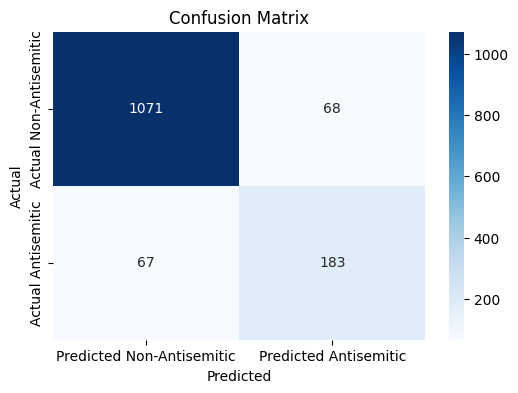

In [ ]:
# Get predictions on the test dataset using the trainer
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Create a DataFrame to display the confusion matrix
cm_df = pd.DataFrame(cm,
                     index=["Actual Non-Antisemitic", "Actual Antisemitic"],
                     columns=["Predicted Non-Antisemitic", "Predicted Antisemitic"])

print("Confusion Matrix:")
print(cm_df)

# Optionally, visualize the confusion matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Predict Tweet function

In [ ]:
def predict_tweet(tweet_text, model):
    """
    Function to predict whether a tweet is antisemitic or not.

    Parameters:
    tweet_text (str): The text of the tweet to be evaluated
    model: The trained RoBERTa model

    Returns:
    tuple: (is_antisemitic (bool), confidence_score (float), full model output)
    """
    import torch
    from transformers import RobertaTokenizerFast
    import re

    # Load the tokenizer
    tokenizer = RobertaTokenizerFast.from_pretrained("RoBERTa-large")

    # Set the model to evaluation mode
    model.eval()

    # Clean the tweet
    cleaned_tweet = clean_text(tweet_text)

    # Tokenize the cleaned tweet
    inputs = tokenizer(cleaned_tweet, return_tensors="pt", truncation=True, padding=True)

    # Move tensors to the model's device (GPU or CPU)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Perform prediction without gradient calculation
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the model's prediction
    logits = outputs.logits

    # Fix the error – move to CPU before converting to NumPy
    probabilities = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()[0]

    # Determine the result (0 = not antisemitic, 1 = antisemitic)
    predicted_class = int(torch.argmax(logits, dim=1).item())
    confidence = float(probabilities[predicted_class])

    # Return the result with interpretation
    is_antisemitic = predicted_class == 1

    return is_antisemitic, confidence, {
        "cleaned_text": cleaned_tweet,
        "probabilities": {
            "non_antisemitic": float(probabilities[0]),
            "antisemitic": float(probabilities[1])
        },
        "prediction": "antisemitic" if is_antisemitic else "not antisemitic"
    }

In [ ]:
model = trainer.model

# Examples of predictions on new tweets
tweet_example1 = "I think Jews control the media and the banks!"
tweet_example2 = "Jews are responsible for all the world’s wars."
tweet_example3 = "All Jewish people are greedy and control the banks."
tweet_example4 = "We need to ban Jews from our country. They’re ruining everything!"
tweet_example5 = "The media is run by a Zionist conspiracy. Wake up!"
tweet_example6 = "I’m attending a cultural festival celebrating Jewish traditions today."
tweet_example7 = "My neighbors are Jewish, and we love sharing holiday meals together."
tweet_example8 = "Many Jewish scientists have contributed significantly to modern physics."
tweet_example9 = "Respecting all backgrounds is crucial for a healthy community."
tweet_example10 = "I love my friends from all backgrounds and religions."

print(f"'{tweet_example1}' --> {predict_tweet(tweet_example1,model)}")
print(f"'{tweet_example2}' --> {predict_tweet(tweet_example2,model)}")
print(f"'{tweet_example3}' --> {predict_tweet(tweet_example3,model)}")
print(f"'{tweet_example4}' --> {predict_tweet(tweet_example4,model)}")
print(f"'{tweet_example5}' --> {predict_tweet(tweet_example5,model)}")
print(f"'{tweet_example6}' --> {predict_tweet(tweet_example6,model)}")
print(f"'{tweet_example7}' --> {predict_tweet(tweet_example7,model)}")
print(f"'{tweet_example8}' --> {predict_tweet(tweet_example8,model)}")
print(f"'{tweet_example9}' --> {predict_tweet(tweet_example9,model)}")
print(f"'{tweet_example10}' --> {predict_tweet(tweet_example10,model)}")




'I think Jews control the media and the banks!' --> (True, 0.9998286962509155, {'cleaned_text': 'i think jews control the media and the banks!', 'probabilities': {'non_antisemitic': 0.00017130508786067367, 'antisemitic': 0.9998286962509155}, 'prediction': 'אנטישמי'})
'Jews are responsible for all the world’s wars.' --> (True, 0.999783456325531, {'cleaned_text': 'jews are responsible for all the worlds wars.', 'probabilities': {'non_antisemitic': 0.00021654239390045404, 'antisemitic': 0.999783456325531}, 'prediction': 'אנטישמי'})
'All Jewish people are greedy and control the banks.' --> (True, 0.9997738003730774, {'cleaned_text': 'all jewish people are greedy and control the banks.', 'probabilities': {'non_antisemitic': 0.00022618471120949835, 'antisemitic': 0.9997738003730774}, 'prediction': 'אנטישמי'})
'We need to ban Jews from our country. They’re ruining everything!' --> (True, 0.9583959579467773, {'cleaned_text': 'we need to ban jews from our country. theyre ruining everything!', '

In [ ]:
tweet_example11 = "Hitler said - kill all the jews they are getting control all over the world - he was right!."

print(f"'{tweet_example11}' --> {predict_tweet(tweet_example11,model)}")

tweet_example12 = "Hitler said - kill all the jews they are getting control all over the world - shame on you hitler! go to hell!!."

print(f"'{tweet_example12}' --> {predict_tweet(tweet_example12,model)}")

'Hitler said - kill all the jews they are getting control all over the world - he was right!.' --> (True, 0.9954445362091064, {'cleaned_text': 'hitler said kill all the jews they are getting control all over the world he was right!.', 'probabilities': {'non_antisemitic': 0.004555494990199804, 'antisemitic': 0.9954445362091064}, 'prediction': 'אנטישמי'})
'Hitler said - kill all the jews they are getting control all over the world - shame on you hitler! go to hell!!.' --> (False, 0.8988615274429321, {'cleaned_text': 'hitler said kill all the jews they are getting control all over the world shame on you hitler! go to hell!!.', 'probabilities': {'non_antisemitic': 0.8988615274429321, 'antisemitic': 0.10113846510648727}, 'prediction': 'לא אנטישמי'})


# ----------------------------------------------------------

# V1 - Bert (Base) with the original data

In [ ]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
import evaluate

os.environ["WANDB_DISABLED"] = "true"

df = pd.read_csv("tweets.csv") 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

df['label'] = df['Biased'].astype(int)

print(df['label'].value_counts())

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = Dataset.from_pandas(train_df[['Cleaned_Text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['Cleaned_Text', 'label']])

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["Cleaned_Text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to=[] 
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate()
print(eval_results)

def predict_tweet(tweet):
    tweet_clean = clean_text(tweet)
    inputs = tokenizer(tweet_clean, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(dim=1).item()
    label = "antisemitic" if prediction == 1 else "non-antisemitic"
    return label


tweet_example1 = "I think Jews control the media and the banks."
tweet_example2 = "I love my friends from all backgrounds and religions."

print(f"'{tweet_example1}' --> {predict_tweet(tweet_example1)}")
print(f"'{tweet_example2}' --> {predict_tweet(tweet_example2)}")



label
0    5691
1    1250
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/5552 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-f62efe74bf4b>:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.332134,0.884809
2,No log,0.322584,0.886969


תוצאות הערכה:
{'eval_loss': 0.3225840628147125, 'eval_accuracy': 0.8869690424766019, 'eval_runtime': 1.2337, 'eval_samples_per_second': 1125.872, 'eval_steps_per_second': 17.832, 'epoch': 2.0}

חיזויים על ציוצים חדשים:
'I think Jews control the media and the banks.' --> non-antisemitic
'I love my friends from all backgrounds and religions.' --> non-antisemitic


Confusion Matrix:
                        Predicted Non-Antisemitic  Predicted Antisemitic
Actual Non-Antisemitic                       1093                     46
Actual Antisemitic                            108                    142


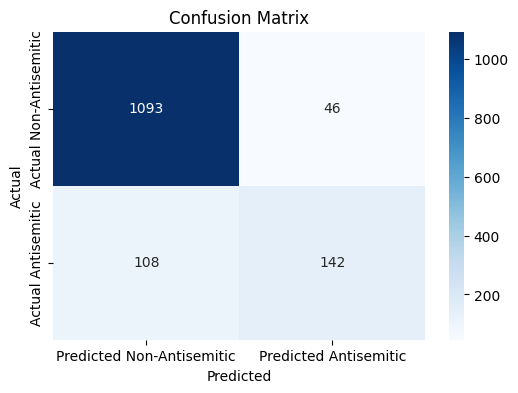

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test dataset using the trainer
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Create a DataFrame to display the confusion matrix
cm_df = pd.DataFrame(cm,
                     index=["Actual Non-Antisemitic", "Actual Antisemitic"],
                     columns=["Predicted Non-Antisemitic", "Predicted Antisemitic"])

print("Confusion Matrix:")
print(cm_df)

# Optionally, visualize the confusion matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [ ]:
tweet_example1 = "jews are getting control the whole world with their big noses"
tweet_example2 = "I am a jew and a hate to eat cheese"

print(f"'{tweet_example1}' --> {predict_tweet(tweet_example1)}")
print(f"'{tweet_example2}' --> {predict_tweet(tweet_example2)}")


חיזויים על ציוצים חדשים:
'jews are getting control the whole world with their big noses' --> antisemitic
'I am a jew and a hate to eat cheese' --> non-antisemitic


# V2 - Bert (Base) With Oversample

In [ ]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
import evaluate

# Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"

# 1. Load the data
df = pd.read_csv("twits.csv")  # Ensure the CSV file is in the same directory or provide the full path

# 2. Define a text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text

# Add a new column with cleaned text
df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Convert the 'Biased' column to numeric labels (assuming values "0" and "1")
df['label'] = df['Biased'].astype(int)

# Check the distribution of labels
print("Original label distribution:")
print(df['label'].value_counts())

# 3. Split the data into train and test sets (80%-20%) with stratification
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 4. Oversample the minority class (antisemitic tweets, label 1) in the training set only
# Separate majority and minority classes in the training set
df_majority = train_df[train_df['label'] == 0]
df_minority = train_df[train_df['label'] == 1]

# Upsample minority class with replacement to match the majority count
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine the majority class with the upsampled minority class
train_df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the oversampled training set
train_df_upsampled = train_df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("Oversampled training label distribution:")
print(train_df_upsampled['label'].value_counts())

# 5. Convert the DataFrames to Hugging Face Datasets (using only the relevant columns)
train_dataset = Dataset.from_pandas(train_df_upsampled[['Cleaned_Text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['Cleaned_Text', 'label']])

# 6. Tokenization using BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["Cleaned_Text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 7. Define the BERT model for sequence classification (2 labels)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 8. Set up training arguments (note: report_to=[] disables any external logging)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to=[]
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 9. Define the evaluation metric (accuracy)
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 10. Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 11. Train the model
trainer.train()

# 12. Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:")
print(eval_results)

# 13. Function to predict the label of new tweets
def predict_tweet(tweet):
    tweet_clean = clean_text(tweet)
    inputs = tokenizer(tweet_clean, return_tensors="pt", truncation=True, padding=True)
    # Ensure tensors are on the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(dim=1).item()
    return "antisemitic" if prediction == 1 else "non-antisemitic"

# Examples for prediction
tweet_example1 = "I think Jews control the media and the banks."
tweet_example2 = "I love my friends from all backgrounds and religions."
tweet_example3 = "I hates jews! they are so theifs."
tweet_example4 = "I am a jew and a hate to eat cheese"
tweet_example5 = "jews are getting control the whole world with their big noses"

print("\nPredictions on new tweets:")
print(f"'{tweet_example1}' --> {predict_tweet(tweet_example1)}")
print(f"'{tweet_example2}' --> {predict_tweet(tweet_example2)}")
print(f"'{tweet_example3}' --> {predict_tweet(tweet_example3)}")
print(f"'{tweet_example4}' --> {predict_tweet(tweet_example4)}")
print(f"'{tweet_example5}' --> {predict_tweet(tweet_example5)}")


Original label distribution:
label
0    5691
1    1250
Name: count, dtype: int64
Oversampled training label distribution:
label
1    4552
0    4552
Name: count, dtype: int64


Map:   0%|          | 0/9104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-18-d859ba051afa>:103: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.390800,0.391049,0.876170
2,0.107500,0.547955,0.889129


Evaluation results:
{'eval_loss': 0.5479552745819092, 'eval_accuracy': 0.8891288696904248, 'eval_runtime': 4.9186, 'eval_samples_per_second': 282.395, 'eval_steps_per_second': 17.688, 'epoch': 2.0}

Predictions on new tweets:
'I think Jews control the media and the banks.' --> antisemitic
'I love my friends from all backgrounds and religions.' --> non-antisemitic
'I hates jews! they are so theifs.' --> non-antisemitic
'I am a jew and a hate to eat cheese' --> antisemitic
'jews are getting control the whole world with their big noses' --> antisemitic


Confusion Matrix:
                        Predicted Non-Antisemitic  Predicted Antisemitic
Actual Non-Antisemitic                       1084                     55
Actual Antisemitic                             99                    151


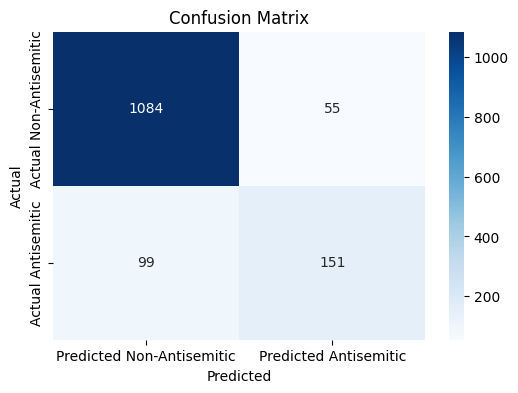

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test dataset using the trainer
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Create a DataFrame to display the confusion matrix
cm_df = pd.DataFrame(cm,
                     index=["Actual Non-Antisemitic", "Actual Antisemitic"],
                     columns=["Predicted Non-Antisemitic", "Predicted Antisemitic"])

print("Confusion Matrix:")
print(cm_df)

# Optionally, visualize the confusion matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [ ]:
tweet_example1 = "jews are getting control the whole world with their big noses"
tweet_example2 = "I am a jew and a hate to eat cheese"

print(f"'{tweet_example1}' --> {predict_tweet(tweet_example1)}")
print(f"'{tweet_example2}' --> {predict_tweet(tweet_example2)}")


חיזויים על ציוצים חדשים:
'jews are getting control the whole world with their big noses' --> antisemitic
'I am a jew and a hate to eat cheese' --> antisemitic


# V3 - Bert (Base) with Undersample

In [ ]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
import evaluate

os.environ["WANDB_DISABLED"] = "true"

df = pd.read_csv("twits.csv")  

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

df['label'] = df['Biased'].astype(int)

print("Label distribution in the full dataset:")
print(df['label'].value_counts())

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print("\nTrain set label distribution BEFORE under-sampling:")
print(train_df['label'].value_counts())


df_majority = train_df[train_df['label'] == 0]
df_minority = train_df[train_df['label'] == 1]

desired_size = 1200

df_majority_undersampled = df_majority.sample(
    n=min(desired_size, len(df_majority)),
    random_state=42,
    replace=False
)

df_minority_undersampled = df_minority.sample(
    n=min(desired_size, len(df_minority)),
    random_state=42,
    replace=False
)

train_df_undersampled = pd.concat([df_majority_undersampled, df_minority_undersampled])
train_df_undersampled = train_df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nTrain set label distribution AFTER under-sampling:")
print(train_df_undersampled['label'].value_counts())

train_dataset = Dataset.from_pandas(train_df_undersampled[['Cleaned_Text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['Cleaned_Text', 'label']])

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["Cleaned_Text"], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to=[] 
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate()
print("\nEvaluation results on the test set:")
print(eval_results)

def predict_tweet(tweet):
    tweet_clean = clean_text(tweet)
    inputs = tokenizer(tweet_clean, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model(**inputs)
    prediction = outputs.logits.argmax(dim=1).item()
    label = "antisemitic" if prediction == 1 else "non-antisemitic"
    return label

tweet_example1 = "I think Jews control the media and the banks."
tweet_example2 = "I love my friends from all backgrounds and religions."

print("\nPredictions on new tweets:")
print(f"'{tweet_example1}' --> {predict_tweet(tweet_example1)}")
print(f"'{tweet_example2}' --> {predict_tweet(tweet_example2)}")


Label distribution in the full dataset:
label
0    5691
1    1250
Name: count, dtype: int64

Train set label distribution BEFORE under-sampling:
label
0    4552
1    1000
Name: count, dtype: int64

Train set label distribution AFTER under-sampling:
label
0    1200
1    1000
Name: count, dtype: int64


Map:   0%|          | 0/2200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-48939117dae5>:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.361258,0.866091
2,No log,0.493601,0.773938
3,No log,0.554577,0.782577
4,0.357300,0.592001,0.812815
5,0.357300,0.623579,0.825774



Evaluation results on the test set:
{'eval_loss': 0.623579204082489, 'eval_accuracy': 0.8257739380849533, 'eval_runtime': 4.785, 'eval_samples_per_second': 290.282, 'eval_steps_per_second': 18.182, 'epoch': 5.0}

Predictions on new tweets:
'I think Jews control the media and the banks.' --> antisemitic
'I love my friends from all backgrounds and religions.' --> non-antisemitic


Confusion Matrix:
                        Predicted Non-Antisemitic  Predicted Antisemitic
Actual Non-Antisemitic                        962                    177
Actual Antisemitic                             65                    185


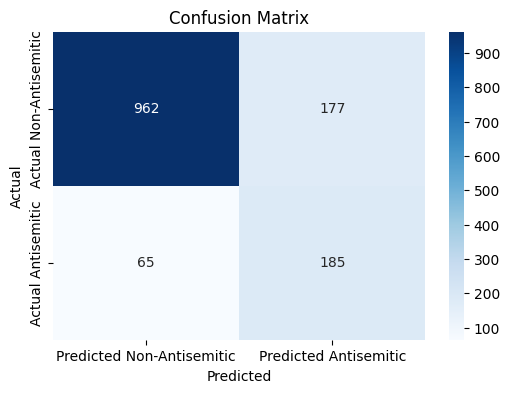

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test dataset using the trainer
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Create a DataFrame to display the confusion matrix
cm_df = pd.DataFrame(cm,
                     index=["Actual Non-Antisemitic", "Actual Antisemitic"],
                     columns=["Predicted Non-Antisemitic", "Predicted Antisemitic"])

print("Confusion Matrix:")
print(cm_df)

# Optionally, visualize the confusion matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
